# SIMPLE WORKING VERSION

# RNN LSTM Chatbot project

In this project I'm creating a chatbot that is supposed to answer questions from the Stanford Questions & Answers dataset SQuAD1, using a sequence-to-sequence Encoder-Decoder recurrent neural network architecture in PyTorch.

To make the notebook more readable and the code more modular, all helper functions (data ingestion and preparation, data analysis, vocabulary creation) were moved to `modules`. 

The model for easier debugging is kept in the main notebook for now.



In [1]:
import torch

In [64]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
from torchtext.datasets import SQuAD1

In [5]:
train, test = SQuAD1("root")

In [6]:
from modules.data import *

#get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data ingestion

* Data is loaded from the dataset into pandas dataframes: one for training, one for testing, 
* To keep the dataset size reasonable, only a sample of the questions/answers is taken

In [7]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [8]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

In [9]:
train_len = 30000
test_len = 3000

In [10]:
train_df = sample_df_num(train_df, train_len)

In [11]:
test_df = sample_df_num(test_df, test_len)

In [12]:
train_df.shape, test_df.shape

((30000, 2), (3000, 2))

In [13]:
train_df.head(3)

,Question,Answer
0,What were computer viruses seen as a threat to?,US operations
1,What stunned neutral observers about the end o...,The quick German victory
2,"The word ""genocide"" was unknown until what year?",1944


## Vocabulary creation / Data preparation

Sentences (questions and answers) are converted into lists of tokens:
* all characters are made into lower case
* punctuation is removed
* stopwords (most common words that don't carry much additional meaning) are removed, but keeping question words (when, how, who, etc.)
* For questions stemming is applied to reduce number of words to just their "roots". For answers this step is skipped, to have full unstemmed words in the answers vocabulary
* Pairs question:answer are created from both train and test dataset, and words are added to two vocabularies: Q_vocab and A_vocab

In [14]:
# Example of the sequence processing

import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

When was the Macintosh Portable first released?
['when', 'macintosh', 'portable', 'first', 'released']
['when', 'macintosh', 'portabl', 'first', 'releas']


In [15]:
from modules.vocab import Vocab

In [16]:
for col, norm in zip(cols, ['stem', None]): # only questions get stemmed
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [17]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [18]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
18318,What new name was given to Revue Productions i...,Universal Television,"[what, new, name, given, revu, product, 1966]","[universal, television]"
18745,What does the State have no legitimate interes...,views distasteful to them,"[what, state, legitim, interest, protect, reli...","[views, distasteful]"
7377,How long did it take to film Spectre?,seven months.,"[how, long, take, film, spectr]","[seven, months]"


In [19]:
# processed sequences columns names have '_tokens' suffix
cols_tokens = [f'{col}_tokens' for col in cols]

### Create pairs and add to the vocabularies

In [20]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [21]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [22]:
Q_vocab, A_vocab = Vocab(), Vocab()

### Words from both training and test datasets are added to the two vocabularies

In [23]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [24]:
Q_vocab.n_words, A_vocab.n_words, 

(17183, 22483)

In [25]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [26]:
# Answers vocabulary contains more words due to lack of stemming

Q_vocab.n_words, A_vocab.n_words 

(18201, 23886)

## Data analysis and further cleanup

To improve and reduce the dataset, some analysis is done to find and remove outliers:
* least common words (those that occur only once)
* answers that have less than one token (empty sequences)
* questions that have less than three tokens, as they're not really meaningful
* histograms are used to find the "long tail" of the dataset: longer sequences are rare, so I establish a threshold above which the dataframe row with either very long question or answer is dropped. This way most of the data is kept, and the sequences can be of reasonable length

In [27]:
from modules.stats import sentences_stats, histograms

In [28]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.43
	         median: 6.00
	         minimum: 0
	         maximum: 24)
Sentences in column Answer_tokens:
	         mean: 2.43
	         median: 2.00
	         minimum: 0
	         maximum: 21)


In [29]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.53
	         median: 6.00
	         minimum: 2
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.40
	         median: 2.00
	         minimum: 0
	         maximum: 18)


### Remove the least common words from the sentences

In [30]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [31]:
print(f'Questions vocabulary has {len(get_outliers(Q_vocab, outlier_threshold+1))} words that occur only once, answers vocabulary has {len(get_outliers(A_vocab, outlier_threshold+1))} such words')

Questions vocabulary has 9102 words that occur only once, answers vocabulary has 14294 such words


### Create lists of those words and remove them from the sequences

In [32]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [33]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [34]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [35]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.15
	         median: 6.00
	         minimum: 0
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.00
	         median: 2.00
	         minimum: 0
	         maximum: 19)


In [36]:
# tokenized & least common removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.25
	         median: 6.00
	         minimum: 1
	         maximum: 16)
Sentences in column Answer_tokens:
	         mean: 1.98
	         median: 2.00
	         minimum: 0
	         maximum: 15)


### Remove questions that have less than three words and answers that have less than one

In [37]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


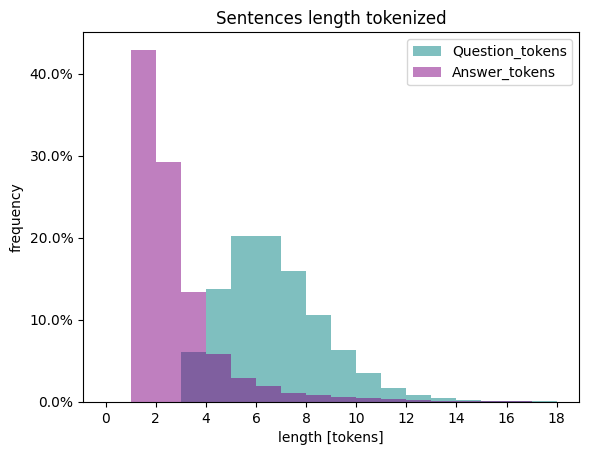

In [38]:
# display the histograms to see if that worked

train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [39]:
train_df_final.shape

(25843, 4)

In [40]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.25
	         median: 6.00
	         minimum: 3
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.26
	         median: 2.00
	         minimum: 1
	         maximum: 19)


In [41]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


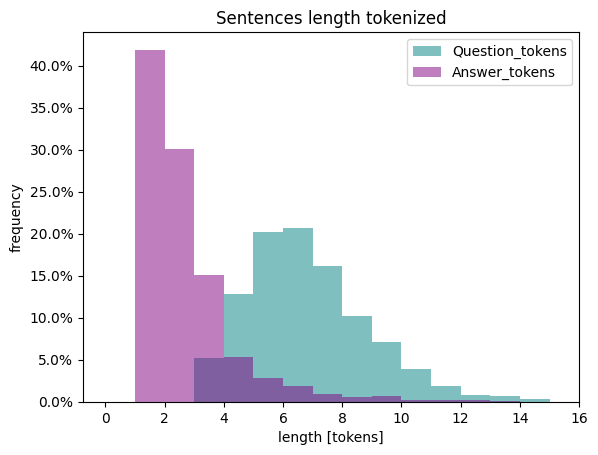

In [42]:
# display the histograms to see if that worked

test_df_final_thresholds = histograms(test_df_final, cols_tokens, name = 'tokenized')

In [43]:
test_df_final.shape

(2608, 4)

In [44]:
# shortest sentences removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.36
	         median: 6.00
	         minimum: 3
	         maximum: 16)
Sentences in column Answer_tokens:
	         mean: 2.20
	         median: 2.00
	         minimum: 1
	         maximum: 15)


### Remove long outliers: long sentences that occure rarely

In [45]:
# keeping only the 95% of the data
cutoff = 95

In [46]:
get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [47]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [48]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [49]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.06
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.99
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [50]:
# to simplify I'm using the same thresholds for the test set

In [51]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [52]:
# long outliers removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.15
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 2.01
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [53]:
train_df_final.shape, test_df_final.shape

((23986, 4), (2431, 4))

### Pairs have to be redone from the cleaned up datasets, to be used in the model (after being turned into tensors).

In [54]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [55]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [56]:
len(train_pairs_final), len(test_pairs_final)

(23986, 2431)

### Data preparation for the neural network model

Sequences are converted into torch tokens made of their vocabulary indexes. Sequences shorter than the defined length are padded at the beginning. Also Start-Of-Sequence and End-Of-Sequence tokens are added to the tensor.

The padding token will be ignored by the model.

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



In [57]:
import torch
import torch.nn as nn

## ENCODER

In [58]:
class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        # embedding step
        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        
        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)        
        x = x.view(1, 1, -1)        
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

## DECODER

In [59]:
class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        # embedding
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # fully connected linear layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
        # softmax
        self.softmax = nn.LogSoftmax(dim=1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

## SEQ2SEQ

In [60]:
class Seq2Seq(nn.Module):

    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    

        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        # make encoder and decoder 
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
                
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        # target batch (answers) is unpacked to maximum length and batch size
        max_len, batch_size = trg_batch.shape               

        trg_vocab_size = self.decoder.output_size
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 
              
        # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)
       
        # iterate over the length of the source (question sequence) using the encoder
        
        for i in range(src_len):       
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            
            # src_batch[i] is the ith token of the input (question)
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        # trg_batch[0] that's just the first element of trg_batch        
        trg = trg_batch[0]
                
        # now iterating over the target length, using the decoder
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            
            # here we use the teacher forcing: if the random value is less than the ratio, then the target is just an element of the target (token from the answer)
            # otherwise it's the highest probability prediction
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

### Model parameters

In [61]:
embedding_dim = 256
hidden_size = 256

### Hyperparameters

In [62]:
learning_rate = 0.005
num_epochs = 25

### Model

In [63]:
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [65]:
seq2seq = seq2seq.to(device)

In [66]:
print(seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18201, 256)
    (lstm): LSTM(256, 256)
  )
  (decoder): Decoder(
    (embedding): Embedding(23886, 256)
    (lstm): LSTM(256, 256)
    (fc): Linear(in_features=256, out_features=23886, bias=True)
    (softmax): LogSoftmax(dim=1)
  )
)


### Optimizer and loss function

In [67]:
from torch import optim
import torch.nn as nn

In [68]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

### Model training 

For debugging purposes the training function is kept in the main notebook for now.

In [69]:
total_train_loss = []
total_test_loss = []

In [70]:
def train(model, pairs, optimizer, criterion, device, teacher_forcing_ratio = 0.5, print_every = 1000): 
    
    model.train() # Set the model to training mode

    total_loss = 0

    count = 0

    for pair in pairs:

        src = pair.question
        tgt = pair.answer

        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        # print(src_tensor.shape, tgt_tensor.shape)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=teacher_forcing_ratio)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        count += 1 

        if count % print_every == 0:
            print(f'Loss {total_loss/count}')

    return total_loss / len(pairs)

In [71]:
def evaluate(model, pairs, criterion, device):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
    
        for pair in pairs:
            
            src = pair.question
            tgt = pair.answer
            
            src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
            tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

            output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=0) # turn off teacher forcing

            # Compute the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

            
            total_loss += loss.item()
        
    return total_loss / len(pairs)

In [72]:
import matplotlib.pyplot as plt

In [ ]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    test_loss = evaluate(seq2seq, test_pairs_final, criterion, device)    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)



Loss 6.382920347452163
Loss 5.89002804851532
Loss 5.691253461519877
Loss 5.526262790620327
Loss 5.410400534582138
Loss 5.311637648661931
Loss 5.237346973146711
Loss 5.180626257702708
Loss 5.130709718717469
Loss 5.086327074944973
Loss 5.046417733420025
Loss 5.018392942845821
Loss 4.988598240283819
Loss 4.9582733383945055
Loss 4.93213903140227
Loss 4.8990520050674675
Loss 4.874832034363466
Loss 4.855231808125973
Loss 4.836137368973933
Loss 4.81757981941104
Loss 4.798355303582691
Loss 4.778018139904195
Loss 4.764972689768542
Epoch 1/25, Train Loss: 4.7540, Test Loss: 4.7105
Loss 4.329474582672119
Loss 4.365325492203236
Loss 4.393886887629827
Loss 4.378279933094978
Loss 4.3730242870092395
Loss 4.3604853079319
Loss 4.355732508744512
Loss 4.355863264083863
Loss 4.353220882058143
Loss 4.350981816518306
Loss 4.346034110578624
Loss 4.3492702013254165
Loss 4.349338210335144
Loss 4.345764980341707


# BIGGER EMBEDDED_DIM AND HIDDEN_SIZE DON'T IMPROVE

In [169]:
N_EPOCHS = 5

Text(0, 0.5, 'loss')

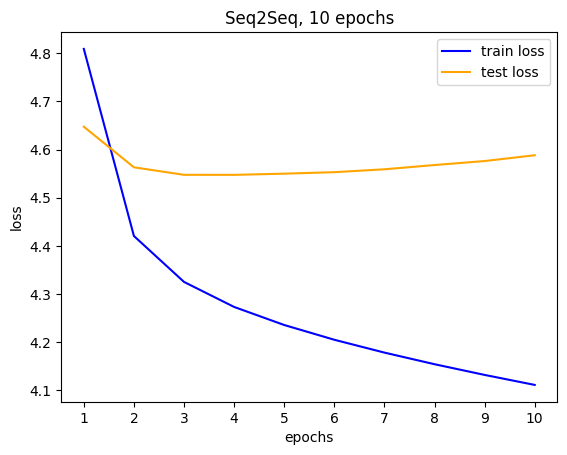

In [99]:
fig, ax = plt.subplots()
ax.plot(range(1, N_EPOCHS+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, N_EPOCHS+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {N_EPOCHS} epochs')
ax.set_xticks(range(1, N_EPOCHS+1))
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

## lower teacher forcing

Text(0, 0.5, 'loss')

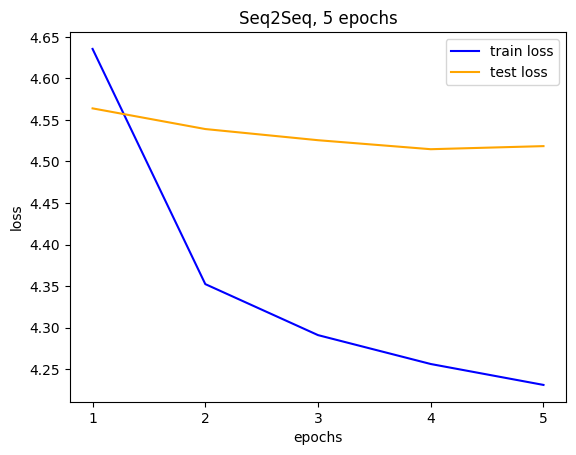

In [170]:
fig, ax = plt.subplots()
ax.plot(range(1, N_EPOCHS+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, N_EPOCHS+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {N_EPOCHS} epochs')
ax.set_xticks(range(1, N_EPOCHS+1))
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

# CURRENT MODEL DOES NOT CONVERGE
# BUT WITH PADDING AT THE END AT LEAST THE TEST LOSS DOES NOT INCREASE... WHY?

# TRYING WITH A DIFFERENT ORDER IN THE SEQUENCE: PADDING AT THE END

In [81]:
def to_tensor(vocab, tokens, seq_len, device):
    '''Converts a tokenized sentence into a tensor of indices of a given length.
    If too short, it uses padding at the END of the sentence'''
    
    tokens = [t for t in tokens if t in vocab.word2count.keys()]
    
    padded = [vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']] + [vocab.word2index['PAD']] * (seq_len-len(tokens)) 
    
    tensor = torch.Tensor(padded).long().to(device).view(-1,1)
    
    return tensor